In [6]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle            #shuffle and randomize the data
import matplotlib.pyplot as plt              #visualization
import cv2                                   #computervision tasks, resize, images reading and pixel manipulation
from sklearn.metrics import confusion_matrix  #Validation matric
import seaborn as sn; sn.set(font_scale=1.4) #visualization and scale set to view proper fonts and add to paper                     #predictions and modeling            
from tqdm import tqdm                # To visualize our loops and progress
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounting google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd drive/My Drive/Colab Notebooks/Images/

/content/drive/My Drive/Colab Notebooks/Images


In [4]:
train_test_directories = ["seg_train","seg_test"]

In [7]:
class_labels = {name:index for index, name in enumerate(os.listdir(train_test_directories[0]))}

In [8]:
class_labels

{'buildings': 3,
 'forest': 4,
 'glacier': 0,
 'mountain': 1,
 'sea': 5,
 'street': 2}

In [10]:
#function for preapring dataset

def prepare_datatset():
    
    resulted_pairs =  []
    
    #first iterate the directories which contain training and testing images
    for directory in train_test_directories:
        #go to each type of image and read images
        
        imagesOfOneType = []
        labelsOfOneType = []
        
        for image_type in (os.listdir(directory)):
            #extract label from created dictionary
            image_label = class_labels[image_type]
            
            #Reading each file and resize it , As some of the images are not consistant in size
            for image in tqdm(os.listdir(os.path.join(directory,image_type))):  #using tqtm for showing the progress bar
                
                img = cv2.imread(os.path.join(os.path.join(directory,image_type),image))
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #reading with color not the greyscale only
                img = cv2.resize(img,(150,150))   #setting up the size of image as 150 * 150 
                
                #writing the image to list imagesOfOneType and respective label to list labelsOfOneType
                
                imagesOfOneType.append(img)
                labelsOfOneType.append(image_label)
                
        imagesOfOneType = np.array(imagesOfOneType, dtype= 'float32')  # setting up float type for RGB, though we have 0-255range
        labelsOfOneType = np.array(labelsOfOneType, dtype='int32')
        
        resulted_pairs.append((imagesOfOneType,labelsOfOneType)) # appending the tupple into resulted output
    
    return resulted_pairs


In [11]:
(training_images, training_labels), (testing_images, testing_labels) = prepare_datatset()

100%|██████████| 510/510 [03:55<00:00,  2.17it/s]


In [59]:
training_images = training_images / 255.0
testing_images = testing_images / 255.0

In [60]:
def show_random_images(image_type, images, labels):
    
    #Display few images to review
    
    fig = plt.figure(figsize=(10,10))
    
    fig.suptitle("Training Examples", fontsize=14)
    
    for j in range(10):
        plt.subplot(5,5,j+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[j], cmap=plt.cm.binary)
    plt.show()

In [63]:
training_images.shape

(14044, 150, 150, 3)

**Convolutional Neural Network**

2 Conv layers, 2 max , flatten and two dense layers

In [10]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [11]:
cnn_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5308544   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 7

In [13]:
history = cnn_model.fit(training_images, training_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 12s 138ms/step - loss: 55.7173 - accuracy: 0.3989 - val_loss: 5.0241 - val_accuracy: 0.1335
Epoch 2/20
88/88 [==============================] - 11s 122ms/step - loss: 0.8900 - accuracy: 0.6769 - val_loss: 6.9945 - val_accuracy: 0.1385
Epoch 3/20
88/88 [==============================] - 11s 122ms/step - loss: 0.4822 - accuracy: 0.8315 - val_loss: 9.1461 - val_accuracy: 0.1289
Epoch 4/20
88/88 [==============================] - 11s 121ms/step - loss: 0.2315 - accuracy: 0.9253 - val_loss: 14.5238 - val_accuracy: 0.1481
Epoch 5/20
88/88 [==============================] - 11s 121ms/step - loss: 0.1207 - accuracy: 0.9668 - val_loss: 19.3289 - val_accuracy: 0.1396
Epoch 6/20
88/88 [==============================] - 11s 121ms/step - loss: 0.0733 - accuracy: 0.9826 - val_loss: 21.9213 - val_accuracy: 0.1627
Epoch 7/20
88/88 [==============================] - 11s 122ms/step - loss: 0.0667 - accuracy: 0.9870 - val_loss: 20.5002 - val_accuracy: 0

In [16]:
import pickle
with open('/cnn_modelHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [17]:
from keras.models import load_model
import h5py
from keras.callbacks import History 
#import keras

cnn_model.save('cnn_model.h5')  # creates a HDF5 file 'my_model.h5'

Using TensorFlow backend.


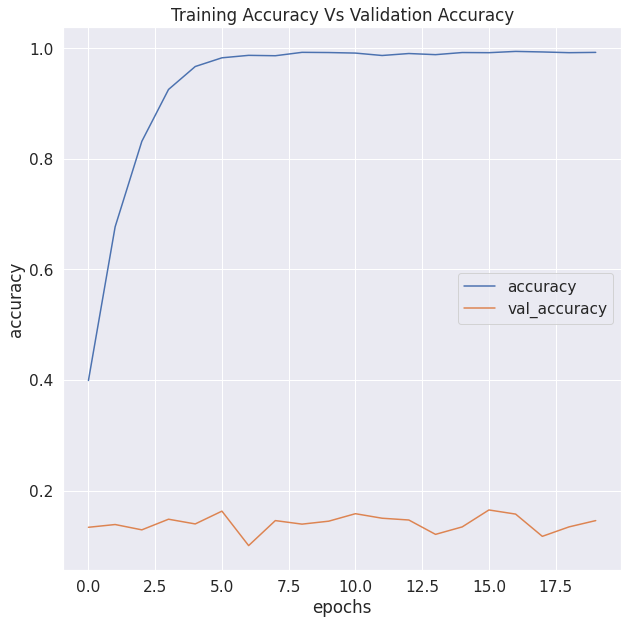

In [24]:
# Plot accuracy vs validation accuracy
fig = plt.figure(figsize=(10,10))
#plt.subplot(221)
plt.plot(cnn_model.history.history['accuracy'], label = "accuracy")
plt.plot(cnn_model.history.history['val_accuracy'], label = "val_accuracy")
plt.title("Training Accuracy Vs Validation Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()
plt.savefig("TrainAccVsValAcc.pdf")

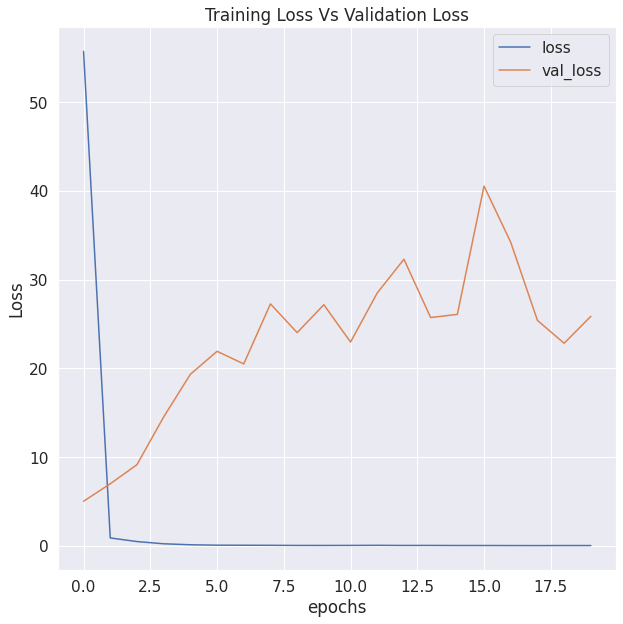

In [25]:
# Plot Loss vs validation loss
fig = plt.figure(figsize=(10,10))
#plt.subplot(221)
plt.plot(cnn_model.history.history['loss'], label = "loss")
plt.plot(cnn_model.history.history['val_loss'], label = "val_loss")
plt.title("Training Loss Vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.savefig("TrainLossVsValLoss.pdf")

In [26]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dotb

In [27]:
cnn_variant = Models.Sequential()

cnn_variant.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
cnn_variant.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
cnn_variant.add(Layers.MaxPool2D(5,5))
cnn_variant.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
cnn_variant.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
cnn_variant.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
cnn_variant.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
cnn_variant.add(Layers.MaxPool2D(5,5))
cnn_variant.add(Layers.Flatten())
cnn_variant.add(Layers.Dense(180,activation='relu'))
cnn_variant.add(Layers.Dense(100,activation='relu'))
cnn_variant.add(Layers.Dense(50,activation='relu'))
cnn_variant.add(Layers.Dropout(rate=0.5))
cnn_variant.add(Layers.Dense(6,activation='softmax'))

In [28]:
cnn_variant.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [29]:
cnn_variant.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 50)       

In [30]:
cnn_variant_history = cnn_variant.fit(training_images,training_labels,epochs=20,validation_split=0.30)

Epoch 1/20
308/308 [==============================] - 199s 646ms/step - loss: 1.3703 - accuracy: 0.4776 - val_loss: 2.8439 - val_accuracy: 0.1735
Epoch 2/20
308/308 [==============================] - 195s 632ms/step - loss: 0.9680 - accuracy: 0.6304 - val_loss: 3.4697 - val_accuracy: 0.1804
Epoch 3/20
308/308 [==============================] - 195s 632ms/step - loss: 0.8148 - accuracy: 0.7010 - val_loss: 3.3326 - val_accuracy: 0.3178
Epoch 4/20
308/308 [==============================] - 195s 632ms/step - loss: 0.7245 - accuracy: 0.7399 - val_loss: 2.9621 - val_accuracy: 0.3806
Epoch 5/20
308/308 [==============================] - 195s 632ms/step - loss: 0.6648 - accuracy: 0.7680 - val_loss: 4.1735 - val_accuracy: 0.2335
Epoch 6/20
308/308 [==============================] - 195s 632ms/step - loss: 0.5946 - accuracy: 0.7900 - val_loss: 3.5117 - val_accuracy: 0.3723
Epoch 7/20
308/308 [==============================] - 195s 632ms/step - loss: 0.5745 - accuracy: 0.7980 - val_loss: 3.4556 -

**Testing With CNN Base Model**

In [35]:
base_model_loss = cnn_model.evaluate(testing_images, testing_labels)

94/94 [==============================] - 2s 16ms/step - loss: 7.2470 - accuracy: 0.5407


In [33]:
base_model_predictions = cnn_model.predict(testing_images)
base_model_predicted_labels = np.argmax(base_model_predictions, axis = 1)

**Testing with Updated Variant of CNN**

In [36]:
variant_model_loss = cnn_variant.evaluate(testing_images, testing_labels)

94/94 [==============================] - 18s 191ms/step - loss: 2.3350 - accuracy: 0.7047


In [46]:
variant_model_predictions = cnn_variant.predict(testing_images)
variant_model_predicted_labels = np.argmax(variant_model_predictions, axis = 1)

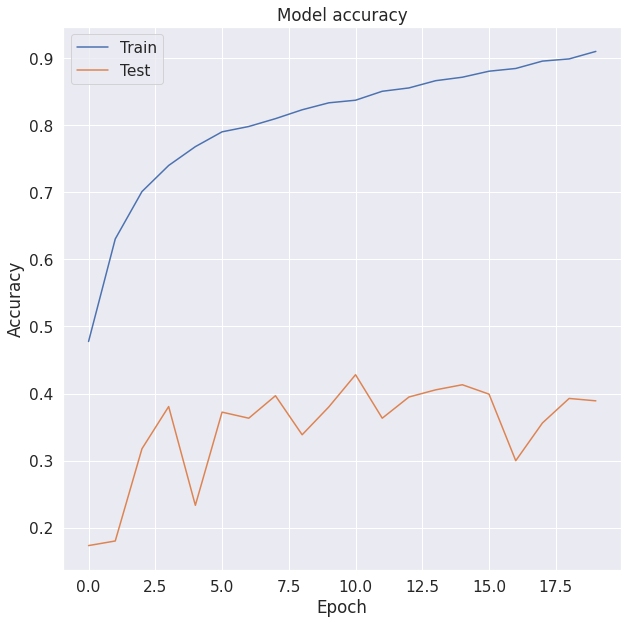

<Figure size 432x288 with 0 Axes>

In [41]:
fig = plt.figure(figsize=(10,10))
plt.plot(cnn_variant_history.history['accuracy'])
plt.plot(cnn_variant_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig("TrainLossVsValLossVariant.pdf")

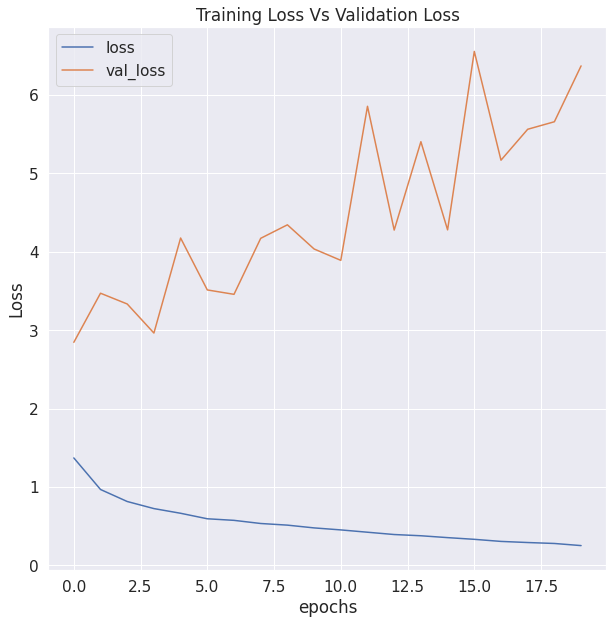

In [44]:
# Plot Loss vs validation loss
fig = plt.figure(figsize=(10,10))
#plt.subplot(221)
plt.plot(cnn_variant_history.history['loss'], label = "loss")
plt.plot(cnn_variant_history.history['val_loss'], label = "val_loss")
plt.title("Training Loss Vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.savefig("TrainLossVsValLossVariant.pdf")

**Confusion Matrix For Base Model**

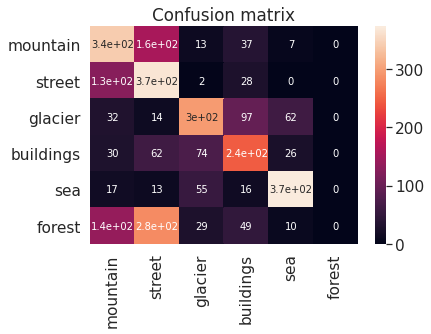

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [50]:
CM = confusion_matrix(testing_labels, base_model_predicted_labels)
ax = plt.axes()
fig = plt.figure(figsize=(10,10))
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels= ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest'], 
           yticklabels= ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest'], ax = ax)
ax.set_title('Confusion matrix')
plt.show()
plt.savefig("ConfusionMatrixForBase")

**Confusion Matrix For Variant Model**

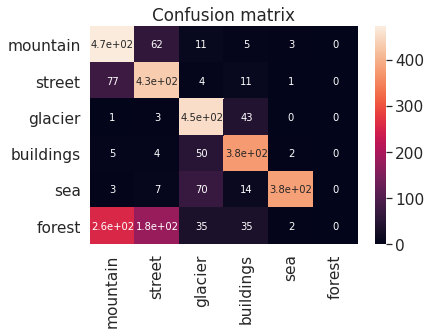

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [51]:
CM = confusion_matrix(testing_labels, variant_model_predicted_labels)
ax = plt.axes()
fig = plt.figure(figsize=(10,10))
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels= ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest'], 
           yticklabels= ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest'], ax = ax)
ax.set_title('Confusion matrix')
plt.show()
plt.savefig("ConfusionMatrixForVariant")

**Transfer Learning - VGG16**

In [57]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

pretrained_model=VGG16(input_shape = (150, 150, 3), 
                        include_top = False, 
                        weights = 'imagenet')

for layer in pretrained_model.layers:
     layer.trainable = False

# pretrained_model.summary()
last_layer = pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output= last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)          

last layer of vgg : output shape:  (None, 4, 4, 512)


In [58]:
model_vgg = Model(pretrained_model.input, x) 


model_vgg.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

# model_vgg.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test))

**Model Fitting**

In [62]:
vgg_History = model_vgg.fit(training_images,training_labels,epochs=10,validation_data=(testing_images,testing_labels))

Epoch 1/10
439/439 [==============================] - 89s 202ms/step - loss: 0.0267 - acc: 0.9986 - val_loss: 1.8054 - val_acc: 0.9023
Epoch 2/10
439/439 [==============================] - 88s 202ms/step - loss: 0.0254 - acc: 0.9988 - val_loss: 1.8073 - val_acc: 0.9090
Epoch 3/10
439/439 [==============================] - 88s 201ms/step - loss: 0.0249 - acc: 0.9989 - val_loss: 2.0191 - val_acc: 0.8990
Epoch 4/10
439/439 [==============================] - 88s 201ms/step - loss: 0.0206 - acc: 0.9987 - val_loss: 1.8105 - val_acc: 0.9053
Epoch 5/10
439/439 [==============================] - 88s 201ms/step - loss: 0.0265 - acc: 0.9987 - val_loss: 1.7674 - val_acc: 0.9067
Epoch 6/10
439/439 [==============================] - 88s 201ms/step - loss: 0.0219 - acc: 0.9986 - val_loss: 1.8843 - val_acc: 0.9060
Epoch 7/10
439/439 [==============================] - 88s 201ms/step - loss: 0.0253 - acc: 0.9988 - val_loss: 1.8938 - val_acc: 0.9050
Epoch 8/10
439/439 [==============================] - 8

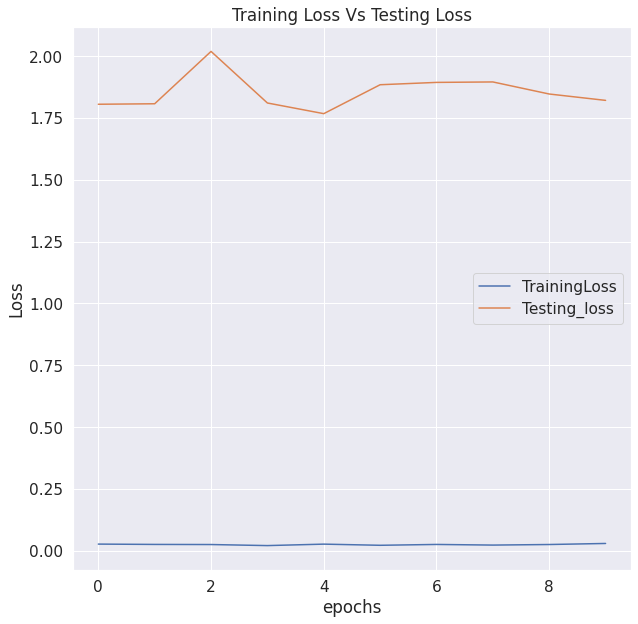

In [64]:
# Plot Loss vs validation loss

#plt.subplot(221)
plt.plot(vgg_History.history['loss'], label = "TrainingLoss")
plt.plot(vgg_History.history['val_loss'], label = "Testing_loss")
plt.title("Training Loss Vs Testing Loss")
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.legend()
plt.savefig("TrainLossVsTestingLossVGG.pdf")

**DENSENET**

In [13]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division


import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
import os
import matplotlib.pyplot as plot
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop


import warnings

from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import AveragePooling2D, MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils.layer_utils import convert_all_kernels_in_model, convert_dense_weights_data_format
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.applications.imagenet_utils import decode_predictions
import keras.backend as K

Using TensorFlow backend.


In [82]:
#Convolutional block

def __conv_block(ip, nb_filter, bottleneck=False, dropout_rate=None, weight_decay=1e-4):
    
    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(ip)
    x = Activation('relu')(x)

    if bottleneck:
        inter_channel = nb_filter * 4 

        x = Conv2D(inter_channel, (1, 1), kernel_initializer='he_normal', padding='same', use_bias=False,
                   kernel_regularizer=l2(weight_decay))(x)
        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(x)
        x = Activation('relu')(x)

    x = Conv2D(nb_filter, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False)(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x

In [83]:
#dense block
def __dense_block(x, nb_layers, nb_filter, growth_rate, bottleneck=False, dropout_rate=None, weight_decay=1e-4,grow_nb_filters=True, return_concat_list=False):
    
    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x_list = [x]

    for i in range(nb_layers):
        cb = __conv_block(x, growth_rate, bottleneck, dropout_rate, weight_decay)
        x_list.append(cb)

        x = concatenate([x, cb], axis=concat_axis)

        if grow_nb_filters:
            nb_filter += growth_rate

    if return_concat_list:
        return x, nb_filter, x_list
    else:
        return x, nb_filter


In [84]:
#Transition Block
def __transition_block(ip, nb_filter, compression=1.0, weight_decay=1e-4):
    ''' Apply BatchNorm, Relu 1x1, Conv2D, optional compression, dropout and Maxpooling2D
    Args:
        ip: keras tensor
        nb_filter: number of filters
        compression: calculated as 1 - reduction. Reduces the number of feature maps
                    in the transition block.
        dropout_rate: dropout rate
        weight_decay: weight decay factor
    Returns: keras tensor, after applying batch_norm, relu-conv, dropout, maxpool
    '''
    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(ip)
    x = Activation('relu')(x)
    x = Conv2D(int(nb_filter * compression), (1, 1), kernel_initializer='he_normal', padding='same', use_bias=False,
               kernel_regularizer=l2(weight_decay))(x)
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)

    return x



In [85]:
#Up-Conv Blocks
def __transition_up_block(ip, nb_filters, type='deconv', weight_decay=1E-4):
    ''' SubpixelConvolutional Upscaling (factor = 2)
    Args:
        ip: keras tensor
        nb_filters: number of layers
        type: can be 'upsampling', 'subpixel', 'deconv'. Determines type of upsampling performed
        weight_decay: weight decay factor
    Returns: keras tensor, after applying upsampling operation.
    '''

    if type == 'upsampling':
        x = UpSampling2D()(ip)
    elif type == 'subpixel':
        x = Conv2D(nb_filters, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay),
                   use_bias=False, kernel_initializer='he_normal')(ip)
        x = SubPixelUpscaling(scale_factor=2)(x)
        x = Conv2D(nb_filters, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay),
                   use_bias=False, kernel_initializer='he_normal')(x)
    else:
        x = Conv2DTranspose(nb_filters, (3, 3), activation='relu', padding='same', strides=(2, 2),
                            kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(ip)

    return x


In [86]:
# Densenet creation
def __create_dense_net(nb_classes, img_input, include_top, depth=40, nb_dense_block=3, growth_rate=12, nb_filter=-1,
                       nb_layers_per_block=-1, bottleneck=False, reduction=0.0, dropout_rate=None, weight_decay=1e-4,
                       subsample_initial_block=False, activation='softmax'):
    
    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1

    if reduction != 0.0:
        assert reduction <= 1.0 and reduction > 0.0, 'reduction value must lie between 0.0 and 1.0'

    # layers in each dense block
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)  # Convert tuple to list

        assert len(nb_layers) == (nb_dense_block), 'If list, nb_layer is used as provided. ' \
                                                   'Note that list size must be (nb_dense_block)'
        final_nb_layer = nb_layers[-1]
        nb_layers = nb_layers[:-1]
    else:
        if nb_layers_per_block == -1:
            assert (depth - 4) % 3 == 0, 'Depth must be 3 N + 4 if nb_layers_per_block == -1'
            count = int((depth - 4) / 3)

            if bottleneck:
                count = count // 2

            nb_layers = [count for _ in range(nb_dense_block)]
            final_nb_layer = count
        else:
            final_nb_layer = nb_layers_per_block
            nb_layers = [nb_layers_per_block] * nb_dense_block

    # compute initial nb_filter if -1, else accept users initial nb_filter
    if nb_filter <= 0:
        nb_filter = 2 * growth_rate

    # compute compression factor
    compression = 1.0 - reduction

    # Initial convolution
    if subsample_initial_block:
        initial_kernel = (7, 7)
        initial_strides = (2, 2)
    else:
        initial_kernel = (3, 3)
        initial_strides = (1, 1)

    x = Conv2D(nb_filter, initial_kernel, kernel_initializer='he_normal', padding='same',
               strides=initial_strides, use_bias=False, kernel_regularizer=l2(weight_decay))(img_input)

    if subsample_initial_block:
        x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(x)
        x = Activation('relu')(x)
        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        x, nb_filter = __dense_block(x, nb_layers[block_idx], nb_filter, growth_rate, bottleneck=bottleneck,
                                     dropout_rate=dropout_rate, weight_decay=weight_decay)
        # add transition_block
        x = __transition_block(x, nb_filter, compression=compression, weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    # The last dense_block does not have a transition_block
    x, nb_filter = __dense_block(x, final_nb_layer, nb_filter, growth_rate, bottleneck=bottleneck,
                                 dropout_rate=dropout_rate, weight_decay=weight_decay)

    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)

    if include_top:
        x = Dense(nb_classes, activation=activation)(x)

    return x

In [87]:
#DenseNet
def DenseNet(input_shape=None, depth=40, nb_dense_block=3, growth_rate=12, nb_filter=-1, nb_layers_per_block=-1,
             bottleneck=False, reduction=0.0, dropout_rate=0.0, weight_decay=1e-4, subsample_initial_block=False,
             include_top=True, weights=None, input_tensor=None,
             classes=10, activation='softmax'):


    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `cifar10` '
                         '(pre-training on CIFAR-10).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as ImageNet with `include_top`'
                         ' as true, `classes` should be 1000')

    if activation not in ['softmax', 'sigmoid']:
        raise ValueError('activation must be one of "softmax" or "sigmoid"')

    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_dense_net(classes, img_input, include_top, depth, nb_dense_block,
                           growth_rate, nb_filter, nb_layers_per_block, bottleneck, reduction,
                           dropout_rate, weight_decay, subsample_initial_block, activation)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='densenet')


    return model

In [88]:
from keras import backend as K
def Implement_focal_loss(gamma=2., alpha=.25):
    
    def focal_loss(y_true, y_pred):
        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)

    return focal_loss

In [89]:
denseNetModel = DenseNet((150, 150, 3), depth=64, nb_dense_block=3,growth_rate=4, bottleneck=True, reduction=0.5, weights=None, classes=6)

In [91]:
optimizer = Adam(lr=0.0001, decay=1e-5)
denseNetModel.compile(loss=[Implement_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=optimizer)

In [92]:
denseNetModel.summary()

Model: "densenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 150, 8)  216         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 150, 150, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 150, 150, 8)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [95]:
DenseNetHistory = denseNetModel.fit(training_images, training_labels, epochs=20, shuffle=True, validation_split=0.3)

Train on 9830 samples, validate on 4214 samples
Epoch 1/20
9830/9830 [==============================] - 568s 58ms/step - loss: 3.0648 - accuracy: 0.0598 - val_loss: 8.6689 - val_accuracy: 0.1445
Epoch 2/20
9830/9830 [==============================] - 547s 56ms/step - loss: 2.9920 - accuracy: 0.1502 - val_loss: 8.6251 - val_accuracy: 0.1901
Epoch 3/20
9830/9830 [==============================] - 547s 56ms/step - loss: 2.9876 - accuracy: 0.1502 - val_loss: 8.6074 - val_accuracy: 0.1137
Epoch 4/20
9830/9830 [==============================] - 547s 56ms/step - loss: 2.9836 - accuracy: 0.1600 - val_loss: 8.5919 - val_accuracy: 0.1664
Epoch 5/20
9830/9830 [==============================] - 546s 56ms/step - loss: 2.9795 - accuracy: 0.1576 - val_loss: 8.5796 - val_accuracy: 0.1768
Epoch 6/20
9830/9830 [==============================] - 547s 56ms/step - loss: 2.9752 - accuracy: 0.1587 - val_loss: 8.5717 - val_accuracy: 0.2311
Epoch 7/20
9830/9830 [==============================] - 547s 56ms/step

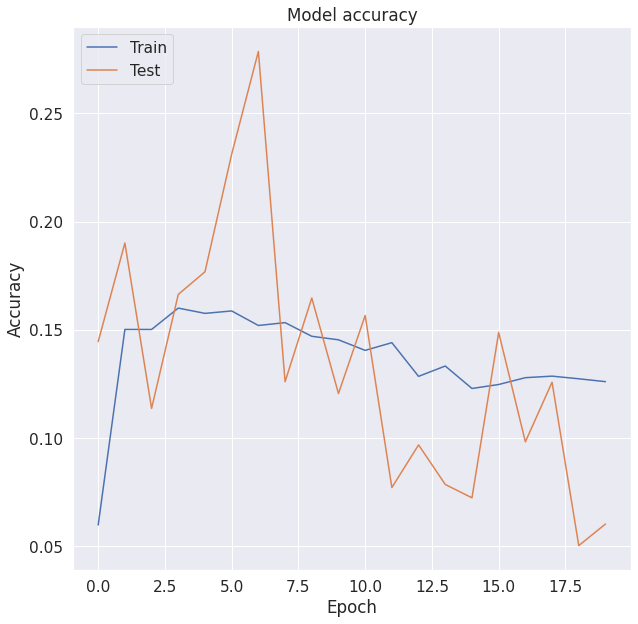

<Figure size 432x288 with 0 Axes>

In [98]:
fig = plot.figure(figsize=(10,10))
plot.plot(DenseNetHistory.history['accuracy'])
plot.plot(DenseNetHistory.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()
plot.savefig("AccuracyVsValAccuFL.pdf")

**Pretrained Resnet**

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

pretrained_model=ResNet50( input_shape=(150,150,3),  #setting up the dimension as per our dataset
                                  include_top=False,
                                  weights='imagenet'  #using imagenet weights
                                   )
# Setting the training false
for layer in pretrained_model.layers:
     layer.trainable = False

        
#step3        
last_layer = pretrained_model.get_layer('conv5_block3_out')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output = last_layer.output

94773248/94765736 [==============================] - 1s 0us/step
last layer of vgg : output shape:  (None, 5, 5, 2048)


In [15]:
#step4
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)

#step5
resnet_model = Model(pretrained_model.input, x) 

#step6
resnet_model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [17]:
resnet_history = resnet_model.fit(training_images,training_labels,epochs=20,validation_data=(testing_images,testing_labels))

Epoch 1/20
439/439 [==============================] - 22s 51ms/step - loss: 0.3265 - acc: 0.9280 - val_loss: 0.5593 - val_acc: 0.8903
Epoch 2/20
439/439 [==============================] - 22s 51ms/step - loss: 0.2295 - acc: 0.9521 - val_loss: 0.5758 - val_acc: 0.9027
Epoch 3/20
439/439 [==============================] - 22s 51ms/step - loss: 0.1462 - acc: 0.9692 - val_loss: 0.7768 - val_acc: 0.9030
Epoch 4/20
439/439 [==============================] - 22s 51ms/step - loss: 0.1162 - acc: 0.9774 - val_loss: 0.7965 - val_acc: 0.9080
Epoch 5/20
439/439 [==============================] - 22s 51ms/step - loss: 0.0792 - acc: 0.9843 - val_loss: 0.9674 - val_acc: 0.9153
Epoch 6/20
439/439 [==============================] - 22s 51ms/step - loss: 0.0739 - acc: 0.9858 - val_loss: 1.1758 - val_acc: 0.9123
Epoch 7/20
439/439 [==============================] - 22s 51ms/step - loss: 0.0613 - acc: 0.9886 - val_loss: 1.1521 - val_acc: 0.9097
Epoch 8/20
439/439 [==============================] - 22s 51ms

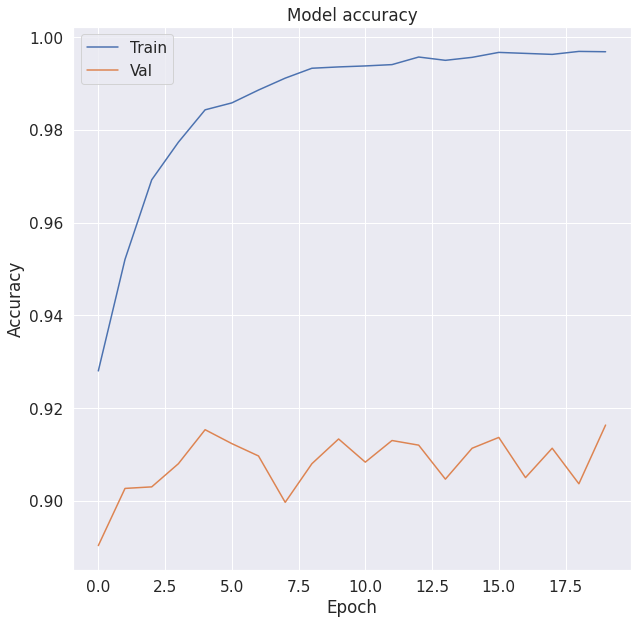

<Figure size 432x288 with 0 Axes>

In [39]:
fig = plot.figure(figsize=(10,10))
plot.plot(resnet_history.history['acc'])
plot.plot(resnet_history.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Val'], loc='upper left')
plot.show()
plot.savefig("AccuracyVsValAccuResnet.pdf")

**InceptionV3**

In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop


pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = "imagenet")

for layer in pre_trained_model.layers:
     layer.trainable = False
        
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

87916544/87910968 [==============================] - 1s 0us/step
last layer output shape:  (None, 7, 7, 768)


In [21]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)           

incept_model = Model(pre_trained_model.input, x) 

incept_model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [22]:
incept_history=incept_model.fit(training_images,training_labels,epochs=20,validation_data=(testing_images,testing_labels))

Epoch 1/20
439/439 [==============================] - 17s 39ms/step - loss: 10.9373 - acc: 0.4578 - val_loss: 1.6690 - val_acc: 0.5230
Epoch 2/20
439/439 [==============================] - 16s 36ms/step - loss: 1.3676 - acc: 0.5414 - val_loss: 1.1864 - val_acc: 0.5850
Epoch 3/20
439/439 [==============================] - 16s 36ms/step - loss: 1.2136 - acc: 0.5862 - val_loss: 2.1260 - val_acc: 0.5267
Epoch 4/20
439/439 [==============================] - 16s 36ms/step - loss: 1.1429 - acc: 0.6102 - val_loss: 1.1940 - val_acc: 0.6237
Epoch 5/20
439/439 [==============================] - 16s 36ms/step - loss: 1.0333 - acc: 0.6396 - val_loss: 1.1618 - val_acc: 0.6233
Epoch 6/20
439/439 [==============================] - 16s 36ms/step - loss: 1.0112 - acc: 0.6550 - val_loss: 1.2523 - val_acc: 0.5990
Epoch 7/20
439/439 [==============================] - 16s 36ms/step - loss: 0.9737 - acc: 0.6685 - val_loss: 1.3912 - val_acc: 0.6237
Epoch 8/20
439/439 [==============================] - 16s 36m

In [23]:
incept_model_loss = incept_model.evaluate(testing_images, testing_labels)

94/94 [==============================] - 2s 24ms/step - loss: 1.8091 - acc: 0.6890


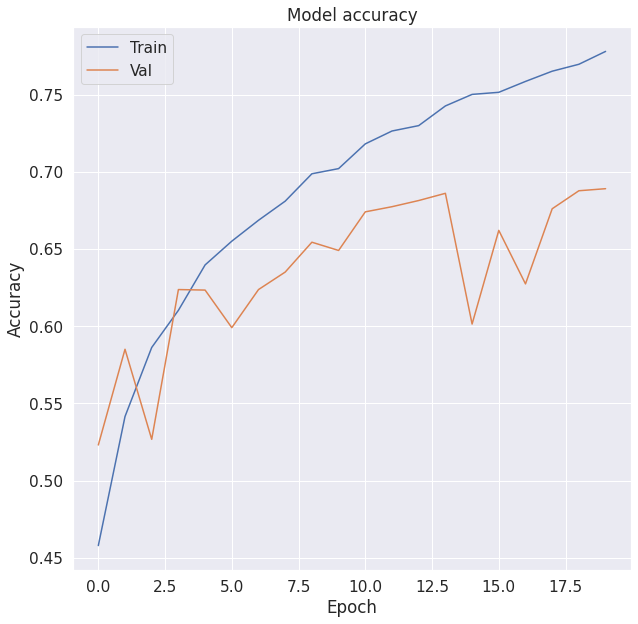

<Figure size 432x288 with 0 Axes>

In [40]:
fig = plot.figure(figsize=(10,10))
plot.plot(incept_history.history['acc'])
plot.plot(incept_history.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Val'], loc='upper left')
plot.show()
plot.savefig("AccuracyVsValAccuInception.pdf")